## FGSM tutorials

* `Explaining and Harnessing Adversarial Examples` 논문 구현 튜토리얼

* [reference](https://tutorials.pytorch.kr/beginner/fgsm_tutorial.html)

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from networks.LeNet import LeNet

### Inputs

* epsilons : adversarial examples를 위해 가해지는 변형의 정도, 클 수록 모델을 속일 수 있지만 사람이 인식할 수 있다. 0 ~ 1 사이의 값을 갖는다.
* pretrained_model
* use_cuda

In [2]:
epsilons = [0, .05, .1]#, .15, .2, .25, .3]
pretrained_model = './models/CIFAR10/10class_not_pretrained/LeNet/lenet_30_cifar_net.pth'
use_cuda = True

### 공격을 받는 모델

In [3]:
# MNIST 테스트 데이터셋과 데이터로더 선언
test_dataset = datasets.CIFAR10(
    root='./datasets/_cifar10/',
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((.5, .5, .5), (.5, .5, .5))
    ])
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=1, shuffle=False, num_workers=2
)

# 어떤 디바이스를 사용할지 정의
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# 모델 초기화하기
model = LeNet(num_classes=10).to(device)

# 미리 학습된 모델 읽어오기
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# 모델을 평가 모드로 설정하기. 드롭아웃 레이어들을 위해 사용됨
model.eval()

Files already downloaded and verified
CUDA Available:  True


LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### FGSM 공격

In [4]:
# FGSM 공격 코드
def fgsm_attack(image, epsilon, data_grad):
    # data_grad 의 요소별 부호 값을 얻어옵니다
    sign_data_grad = data_grad.sign()
    # 입력 이미지의 각 픽셀에 sign_data_grad 를 적용해 작은 변화가 적용된 이미지를 생성합니다
    perturbed_image = image + epsilon * sign_data_grad
    # 값 범위를 [0,1]로 유지하기 위해 자르기(clipping)를 추가합니다
#     perturbed_image = torch.clamp(perturbed_image, 0, 255)
    perturbed_image = torch.clamp(perturbed_image, 0, 255)
    # 작은 변화가 적용된 이미지를 리턴합니다
    return perturbed_image

### 테스트 함수

In [5]:
def test( model, device, test_loader, epsilon ):

    # 정확도 카운터
    correct = 0
    adv_examples = []
#     a = []

    # 테스트 셋의 모든 예제에 대해 루프를 돕니다
    for data, target in tqdm(test_loader):

        # 디바이스(CPU or GPU) 에 데이터와 라벨 값을 보냅니다
        data, target = data.to(device), target.to(device)

        # 텐서의 속성 중 requires_grad 를 설정합니다. 공격에서 중요한 부분입니다
        data.requires_grad = True

        # 데이터를 모델에 통과시킵니다
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # 로그 확률의 최대값을 가지는 인덱스를 얻습니다

        # 만약 초기 예측이 틀리면, 공격하지 않도록 하고 계속 진행합니다
        if init_pred.item() != target.item():
            continue

        # 손실을 계산합니다
        loss = F.nll_loss(output, target)

        # 모델의 변화도들을 전부 0으로 설정합니다
        model.zero_grad()

        # 후방 전달을 통해 모델의 변화도를 계산합니다
        loss.backward()

        # 변화도 값을 모읍니다
        data_grad = data.grad.data

        # FGSM 공격을 호출합니다
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
#         a.append(perturbed_data.cpu()) # a가 진짜
        
        # 작은 변화가 적용된 이미지에 대해 재분류합니다
        output = model(perturbed_data)

        # 올바른지 확인합니다
        final_pred = output.max(1, keepdim=True)[1] # 로그 확률의 최대값을 가지는 인덱스를 얻습니다
        if final_pred.item() == target.item():
            correct += 1
            if epsilon == 0:
                adv_ex = perturbed_data.cpu()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
                # 0 엡실론 예제에 대해서 저장합니다(원본))
#             if (epsilon == 0) and (len(adv_examples) < 5):
#                 adv_ex = perturbed_data.detach().cpu().numpy()#squeeze().detach().cpu().numpy()
#                 adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # 추후 시각화를 위하 다른 예제들을 저장합니다
#             if len(adv_examples) < 5:
#                 adv_ex = perturbed_data.detach().cpu().numpy()#squeeze().detach().cpu().numpy()
#                 adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
            adv_ex = perturbed_data.cpu()
            adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # 해당 엡실론에서의 최종 정확도를 계산합니다
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # 정확도와 적대적 예제를 리턴합니다
    return final_acc, adv_examples#, a

### 공격 코드

In [6]:
accuracies = []
examples = []
# _ex = [] # _ex가 진짜

# 각 엡실론에 대해 테스트 함수를 실행합니다
for eps in epsilons:
    print(str(eps) + ' started' + '=' * 20)
    acc, ex = test(model, device, test_loader, eps)#, a = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)
#     _ex.append(a)

  0%|          | 0/10000 [00:00<?, ?it/s]

0 started====================


  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0	Test Accuracy = 2661 / 10000 = 0.2661
0.05 started====================


  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.05	Test Accuracy = 1164 / 10000 = 0.1164
0.1 started====================


100%|██████████| 10000/10000 [00:36<00:00, 275.28it/s]

Epsilon: 0.1	Test Accuracy = 573 / 10000 = 0.0573


### 정확도와 엡실론 가시화

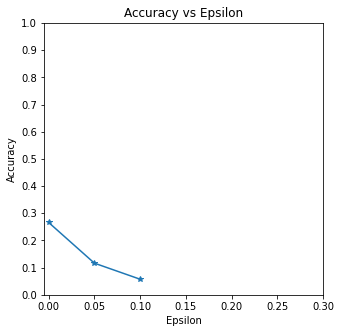

In [7]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

### 적대적 샘플 가시화

In [ ]:
from PIL import Image
import cv2

# 각 엡실론에서 적대적 샘플의 몇 가지 예를 도식화합니다
cnt = 0
plt.figure(figsize=(8,10))
# 가시화
tf = tf = transforms.ToPILImage()
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
#         _exex = examples[i][j]
#         plt.title("{} -> {}".format(orig, adv))
        # 이미지 저장
#         plt.imshow(tf(ex[0]))#, cmap='gray')
        tf(ex[0]).save('./adversarial_examples/' + str(epsilons[i]) + '_' + str(cnt) + '_test.jpg')
plt.tight_layout()
plt.show()

In [16]:
img = cv2.imread('./test.png')

# print(img.shape)
color_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
cv2.imwrite('./_test.png', color_image)

True

In [8]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
    return npimg

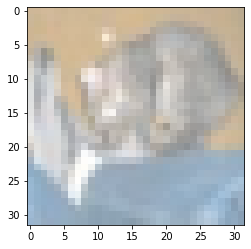

tensor([[[[0.6196, 0.6235, 0.6471,  ..., 0.5373, 0.4941, 0.4549],
          [0.5961, 0.5922, 0.6235,  ..., 0.5333, 0.4902, 0.4667],
          [0.5922, 0.5922, 0.6196,  ..., 0.5451, 0.5098, 0.4706],
          ...,
          [0.2667, 0.1647, 0.1216,  ..., 0.1490, 0.0510, 0.1569],
          [0.2392, 0.1922, 0.1373,  ..., 0.1020, 0.1137, 0.0784],
          [0.2118, 0.2196, 0.1765,  ..., 0.0941, 0.1333, 0.0824]],

         [[0.4392, 0.4353, 0.4549,  ..., 0.3725, 0.3569, 0.3333],
          [0.4392, 0.4314, 0.4471,  ..., 0.3725, 0.3569, 0.3451],
          [0.4314, 0.4275, 0.4353,  ..., 0.3843, 0.3725, 0.3490],
          ...,
          [0.4863, 0.3922, 0.3451,  ..., 0.3804, 0.2510, 0.3333],
          [0.4549, 0.4000, 0.3333,  ..., 0.3216, 0.3216, 0.2510],
          [0.4196, 0.4118, 0.3490,  ..., 0.3020, 0.3294, 0.2627]],

         [[0.1922, 0.1843, 0.2000,  ..., 0.1412, 0.1412, 0.1294],
          [0.2000, 0.1569, 0.1765,  ..., 0.1216, 0.1255, 0.1333],
          [0.1843, 0.1294, 0.1412,  ..., 0

In [10]:
import torchvision
from PIL import Image

dataiter = iter(test_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(images)
data = images.squeeze().detach().cpu().numpy()
print(data[0])
data = Image.fromarray(data[0])
data.save('./_test.tiff')

In [14]:
p_data = _ex[0][0][0].cpu()

tf = transforms.ToPILImage()
img_tf = tf(p_data)

print(img_tf)
img_tf.save('./_ttest.jpg')

<PIL.Image.Image image mode=RGB size=32x32 at 0x7FCD90A61B38>
